Writeup Template(https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md)

Advanced Lane Finding Project

The goals / steps of this project are the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
Apply a distortion correction to raw images.
Use color transforms, gradients, etc., to create a thresholded binary image.
Apply a perspective transform to rectify binary image ("birds-eye view").
Detect lane pixels and fit to find the lane boundary.
Determine the curvature of the lane and vehicle position with respect to center.
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import cv2
import os
from math import *
import glob

%matplotlib inline

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test/calibration image using the cv2.undistort() function and obtained this result:

In [3]:
def calibrate_camera(cal_images, nx, ny):
    objpoints = []  # 3D points
    imgpoints = []  # 2D points

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname = cal_images[0]
    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist

def camera_setup():
    cal_images = glob.glob('camera_cal/calibration*.jpg')
    nx, ny = 9, 6
    cam_mtx, cam_dist = calibrate_camera(cal_images, nx, ny)
    return cam_mtx, cam_dist



* Apply the distortion correction to the calibration and test image.  

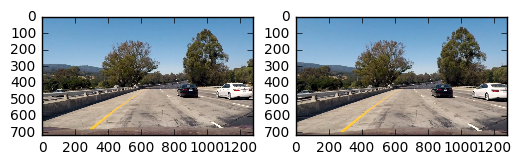

In [4]:
cam_mtx, cam_dist = camera_setup()
image = mpimg.imread('test_images/test1.jpg')
undist = cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(undist)
plt.show()

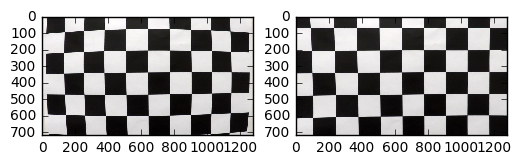

In [5]:
image = mpimg.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(undist)
plt.show()

* Use color transforms, gradients, etc., to create a thresholded binary image.


I used a combination of color and gradient thresholds and image masks to generate a binary image. Here's an example of my output for this step. Both grayscale and S channel were applied gradient magnitude throshold and yellow mask. If S channel does not have sufficient data, then use grayscale image.

Thresholds for S channel:
    _, s_binary = cv2.threshold(S.astype('uint8'), 130, 255, cv2.THRESH_BINARY)

    Ssobelx = sobel(S, orient='x', sobel_kernel=ksize)
    Sgradx = abs_sobel_thresh(sobelx, thresh=(50, 90))
    Ssobely = sobel(S, orient='y', sobel_kernel=ksize)
    Sgrady = abs_sobel_thresh(sobely, thresh=(70, 120))
    Smag_binary = mag_thresh(Ssobelx, Ssobely, thresh=(50, 100))

Thresholds for grayscale:
    _, gray_binary = cv2.threshold(gray.astype('uint8'), 130, 255, cv2.THRESH_BINARY)

    Gsobelx = sobel(gray, orient='x', sobel_kernel=ksize)
    Ggradx = abs_sobel_thresh(sobelx, thresh=(60, 70))
    Gsobely = sobel(gray, orient='y', sobel_kernel=ksize)
    Ggrady = abs_sobel_thresh(sobely, thresh=(50, 120))
    Gmag_binary = mag_thresh(Gsobelx, Gsobely, thresh=(50, 100))

In [6]:
def sobel(img, orient='x', sobel_kernel=3):
    return cv2.Sobel(img, cv2.CV_64F, orient == 'x', orient == 'y', ksize=sobel_kernel)

def abs_sobel_thresh(sobel, thresh=(0, 255)):
    # Calculate absolute gradient
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    retval, output = cv2.threshold(scaled_sobel, thresh[0], thresh[1], cv2.THRESH_BINARY)
    return output

def mag_thresh(sobelx, sobely, thresh=(0, 255)):
    # Calculate gradient magnitude
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    mag_sobel = (255*mag_sobel/np.max(mag_sobel)).astype(np.uint8)

    retval, output = cv2.threshold(mag_sobel, thresh[0], thresh[1], cv2.THRESH_BINARY)
    return output

def dir_threshold(sobelx, sobely, thresh=(0, np.pi/2)):
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [7]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [33]:
def find_edges(image, ksize = 5, display=False, mask=True):
    #blur = cv2.GaussianBlur(image, (3, ksize), 0)
    # https://www.packtpub.com/mapt/book/Application+Development/9781785283932/2/ch02lvl1sec22/Sharpening
    kernel_sharpen_3 = np.array([[-1,-1,-1,-1,-1],
                             [-1,2,2,2,-1],
                             [-1,2,8,2,-1],
                             [-1,2,2,2,-1],
                             [-1,-1,-1,-1,-1]]) / 8.0
    image = cv2.filter2D(image, -1, kernel_sharpen_3)
    hls = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2HLS)

    gray = (0.5*image[:,:,0] + 0.4*image[:,:,1] + 0.1*image[:,:,2]).astype(np.uint8)
    s = hls[:,:,2]
    
    _, gray_binary = cv2.threshold(gray.astype('uint8'), 150, 255, cv2.THRESH_BINARY)

    total_px = image.shape[0]*image.shape[1]
    laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
    mask_three = (laplacian < 0.15*np.min(laplacian)).astype(np.uint8)
    if cv2.countNonZero(mask_three)/total_px < 0.01:
        laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
        mask_three = (laplacian < 0.075*np.min(laplacian)).astype(np.uint8)

    _, s_binary = cv2.threshold(s.astype('uint8'), 150, 255, cv2.THRESH_BINARY)
    mask_two = s_binary

    binary_image = np.clip(cv2.bitwise_and(gray_binary, 
                        cv2.bitwise_or(mask_three, mask_two)), 0, 1).astype('uint8')
#     gray = (cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2GRAY))
#     _, gray_binary = cv2.threshold(gray.astype('uint8'), 130, 255, cv2.THRESH_BINARY)
#     HLS = (cv2.cvtColor(image, cv2.COLOR_RGB2HLS))
#     #H = hls[:,:,0]
#     #L = hls[:,:,1]
#     S = HLS[:,:,2]
#     _, s_binary = cv2.threshold(S.astype('uint8'), 130, 255, cv2.THRESH_BINARY)
    
#     Ssobelx = sobel(S, orient='x', sobel_kernel=ksize)
#     Sgradx = abs_sobel_thresh(Ssobelx, thresh=(50, 90))

#     Ssobely = sobel(S, orient='y', sobel_kernel=ksize)
#     Sgrady = abs_sobel_thresh(Ssobely, thresh=(70, 120))

#     Smag_binary = mag_thresh(Ssobelx, Ssobely, thresh=(50, 100))

#     Gsobelx = sobel(gray, orient='x', sobel_kernel=ksize)
#     Ggradx = abs_sobel_thresh(Gsobelx, thresh=(60, 70))

#     Gsobely = sobel(gray, orient='y', sobel_kernel=ksize)
#     Ggrady = abs_sobel_thresh(Gsobely, thresh=(50, 120))

#     Gmag_binary = mag_thresh(Gsobelx, Gsobely, thresh=(50, 100))
    
#     yellow = (np.array([160, 128, 0]), np.array([255, 255, 128]))
#     yellow_mask = (cv2.inRange(image, yellow[0], yellow[1])/255.0).astype(np.uint8)
    
#     combined_mask_one = cv2.bitwise_or(Smag_binary, yellow_mask).astype('uint8')
#     combined_mask_two = cv2.bitwise_or(Gmag_binary, yellow_mask).astype('uint8')

#     combined_binary_one = np.zeros_like(S)
#     combined_binary_two = np.zeros_like(S)

#     combined_binary_one = np.clip(cv2.bitwise_and(S, combined_mask_one),0,1).astype('uint8')
#     combined_binary_two = np.clip(cv2.bitwise_and(gray_binary, combined_mask_two),0,1).astype('uint8')

#     total_px = combined_binary_one.shape[0]*combined_binary_one.shape[1]/2
#     condition = cv2.countNonZero(combined_binary_one[combined_binary_one.shape[0]/2:])/total_px

#     if  condition < 0.05:
#         binary_image = combined_binary_two
#         #print('return mask two', condition)
#     else:
#         binary_image = combined_binary_one
#         #print('return mask one', condition)
    
    masked_image = np.copy(binary_image)

    if mask:
        imshape = masked_image.shape
        vertices = np.array([[(0,imshape[0]),(620, 430), (720, 430), (imshape[1],imshape[0])]], dtype=np.int32)
        masked_image = region_of_interest(masked_image, vertices)
        vertices = np.array([[(330,imshape[0]),(660, 470), (660, 470), (1100,imshape[0])]], dtype=np.int32)
        cv2.fillPoly(masked_image, vertices, 0)
    if display:
        plt.subplot(3, 3, 1)
        plt.imshow(gradx, cmap='gray')
        plt.title('gradx')
        plt.subplot(3, 3, 2)
        plt.imshow(grady, cmap='gray')
        plt.title('grady')
        plt.subplot(3, 3, 3)
        plt.imshow(mag_binary, cmap='gray')
        plt.title('mag_binary')
        plt.subplot(3, 3, 4)
        plt.imshow(combined_mask_one, cmap='gray')
        plt.title('combined_mask_one')
        plt.subplot(3, 3, 5)
        plt.imshow(combined_mask_two, cmap='gray')
        plt.title('combined_mask_two')
        plt.subplot(3, 3, 6)
        plt.imshow(combined_binary_one, cmap='gray')
        plt.title('combined_binary_one')
        plt.subplot(3, 3, 7)
        plt.imshow(combined_binary_two, cmap='gray')
        plt.title('combined_binary_two')
        plt.subplot(3, 3, 8)
        plt.imshow(masked_image, cmap='gray')
        plt.title('masked_image')
    return masked_image




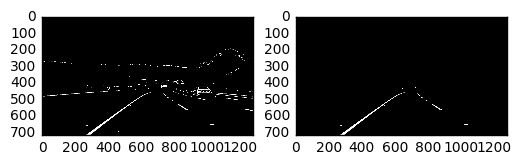

In [40]:
image = mpimg.imread('test_images/test3.jpg')
#print(image.shape)
undist = cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)
#binary_image = find_edges(undist)


binary_image_nomask = find_edges(undist, mask=False)
binary_image_mask = find_edges(undist)
plt.subplot(1,2,1)
plt.imshow(binary_image_nomask, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(binary_image_mask, cmap='gray')
plt.show()

* Apply a perspective transform to rectify binary image ("birds-eye view"). 


The code for my perspective transform includes a function called warp_image(), which appears in the following code cell. The warp_image() function takes as inputs an binary image (img). Src points are calculated from image input, if otherwise not found, a hard coded src points will be used. destination (dst) points are hard coded.

Hard coded source points
    
    src = np.array([[585. /1280.*img_size[1], 455./720.*img_size[0]],
                    [705. /1280.*img_size[1], 455./720.*img_size[0]],
                    [1130./1280.*img_size[1], 720./720.*img_size[0]],
                    [190. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)

Hard coded destination points

    dst = np.array([[300. /1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 720./720.*img_size[0]],
                        [300. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)


In [29]:
def warp_image(img, display=False):
    try:
        img_size = img.shape

        rho = 1              # distance resolution in pixels of the Hough grid
        theta = 1*np.pi/180  # angular resolution in radians of the Hough grid
        threshold = 20       # minimum number of votes (intersections in Hough grid cell)
        min_line_length = 40 # minimum number of pixels making up a line
        max_line_gap = 25    # maximum gap in pixels between connectable line segments

        angle_min_mag = 25*pi/180
        angle_max_mag = 50*pi/180

        lane_markers_x = [[], []]
        lane_markers_y = [[], []]

        lines = cv2.HoughLinesP(img, rho, theta, threshold, min_line_length, max_line_gap)
        for line in lines:
            for x1,y1,x2,y2 in line:
                theta = atan2(y1-y2, x2-x1)
                rho = ((x1+x2)*cos(theta) + (y1+y2)*sin(theta))/2

                if (abs(theta) >= angle_min_mag and abs(theta) <= angle_max_mag):
                    if theta > 0: # positive theta is downward in image space?
                        i = 0 # Left lane marker
                    else:
                        i = 1 # Right lane marker
                    lane_markers_x[i].append(x1)
                    lane_markers_x[i].append(x2)
                    lane_markers_y[i].append(y1)
                    lane_markers_y[i].append(y2)

        p_left  = np.polyfit(lane_markers_y[0], lane_markers_x[0], 1)
        p_right = np.polyfit(lane_markers_y[1], lane_markers_x[1], 1)

        # Find intersection of the two lines
        apex_pt = np.linalg.solve([[p_left[0], -1], [p_right[0], -1]], [-p_left[1], -p_right[1]])
        top_y = ceil(apex_pt[0] + 0.075*img.shape[0])
        #print(top_y)

        bl_pt = ceil(np.polyval(p_left, img.shape[0]))
        tl_pt = ceil(np.polyval(p_left, top_y))

        br_pt = ceil(np.polyval(p_right, img.shape[0]))
        tr_pt = ceil(np.polyval(p_right, top_y))

        src = np.array([[tl_pt, top_y],
                        [tr_pt, top_y],
                        [br_pt, img.shape[0]],
                        [bl_pt, img.shape[0]]], np.float32)
    except Exception as e:
        print(e)
        src = np.array([[585. /1280.*img_size[1], 455./720.*img_size[0]],
                        [705. /1280.*img_size[1], 455./720.*img_size[0]],
                        [1130./1280.*img_size[1], 720./720.*img_size[0]],
                        [190. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
    
    dst = np.array([[300. /1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 720./720.*img_size[0]],
                        [300. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
    #print(src)
    #print(dst)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the image using OpenCV warpPerspective()
    #warped = cv2.warpPerspective(img, M, (image.shape[1], image.shape[0]))
    if display:
        plt.subplot(1,2,1)
        plt.hold(True)
        plt.imshow(img, cmap='gray')
        for i in range(4):
            plt.plot(src[i,0],src[i,1],'r.')

        im2 = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        plt.subplot(1,2,2)
        plt.hold(True)
        plt.imshow(im2, cmap='gray')
        for i in range(4):
            plt.plot(dst[i,0],dst[i,1],'r.')
        plt.show()
        
    return M, Minv, src



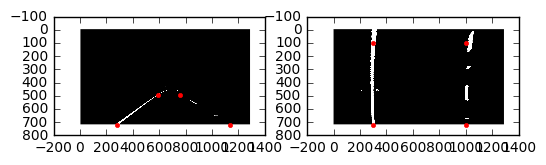

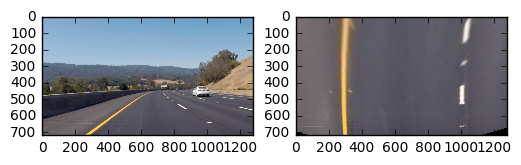

In [43]:
image = mpimg.imread('test_images/test3.jpg')
undist = cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)

edges = find_edges(undist)

warp_m, warp_minv, _ = warp_image(edges,display=True)
lanes = cv2.warpPerspective(image, warp_m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(lanes)

plt.show()



* Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:



/Users/brandon/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(720, 0)

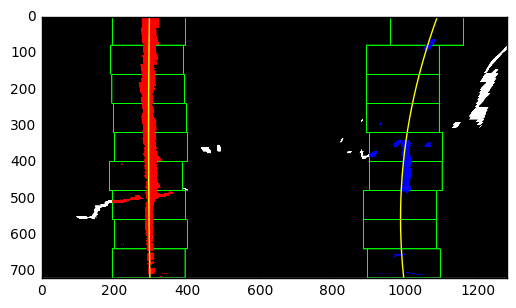

In [39]:
image = mpimg.imread('test_images/test4.jpg')

undist = cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)

edges = find_edges(undist)

warp_m, warp_minv, _ = warp_image(edges)
binary_warped = cv2.warpPerspective(edges, warp_m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)



* calculate curvature


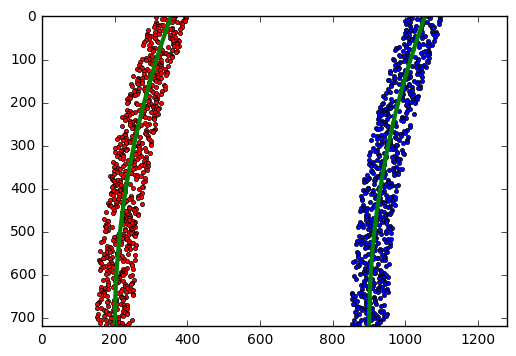

In [29]:
# image = mpimg.imread('test_images/test5.jpg')
# undist = cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)

# edges = find_edges(undist)

# warp_m, warp_minv = warp_image(edges)

# binary_warped = cv2.warpPerspective(edges, warp_m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
# left_fitx, right_fitx = detect_from_scratch(binary_warped)

# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [30]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1514.51169108 1772.16052304

1670.35062889 1685.45732589


In [31]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 497.280683297 m 581.547376422 m

548.632400605 m 553.594123491 m


* Define our Lane line class

In [16]:
# Define a class to receive the characteristics of each line detection
import collections
from itertools import chain, repeat
    
class Lane():
    def __init__(self, img_size):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = collections.deque(maxlen=10)
        self.recent_yfitted = collections.deque(maxlen=10)
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None   
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.curvature = None 
        #distance in meters of vehicle center from the line
        self.pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.current_xfit = None
        self.roi_mask = None
        
        self.img_size = img_size
        
        self.yvals = np.linspace(0, img_size[0], 101)
        self.mask = np.ones(img_size, dtype=np.uint8)*255
        
        self.dropped_frames = 0
    
    def add_lane_pixels(self, x, y):
        # Use all pixels from previous detections for curve fit
        x_hist = np.fromiter(chain(*self.recent_xfitted, x), np.int32)
        y_hist = np.fromiter(chain(*self.recent_yfitted, y), np.int32)

        try:
            p_lane = np.polyfit(y_hist, x_hist, 2)
            rad_curv = self.calculate_rad_curv(x_hist, y_hist)
            self.detected = self.sanity_check_lane(rad_curv)
        except Exception as e:
            print(e)
            self.detected = False

        if self.detected and len(p_lane) == 3:
            self.current_fit = p_lane
            x_fit = p_lane[0]*self.yvals**2 + p_lane[1]*self.yvals + p_lane[2]
        
            self.current_xfit = x_fit   # For drawing
            
            self.curvature = rad_curv
            # Save current detected pixels
            self.allx = np.array(x)
            self.ally = np.array(y)

            self.recent_xfitted.append(x_fit)
            self.recent_yfitted.append(self.yvals)
            if len(self.current_fit) > 1:
                self.diffs = self.current_fit - p_lane
            
            self.dropped_frames = 0
        else:
            # Use last fit if current one failed
            p_lane = self.current_fit
            x_fit = p_lane[0]*self.yvals**2 + p_lane[1]*self.yvals + p_lane[2]
            self.dropped_frames += 1
            rad_curv = self.curvature
            
        self.mask.fill(0)
        # http://stackoverflow.com/a/35902430/538379 
        pts = np.transpose(np.vstack([x_fit, self.yvals])).reshape((-1,1,2)).astype(np.int32)
        cv2.drawContours(self.mask, pts, -1, (255,255,255), thickness=80)        
        

    
    def sanity_check_lane(self, R):
        # Return true if there is no prior data
        if self.curvature is None:
            return True
        
        k = 1/R   # Curvature is a better measure to track
        R0 = self.curvature
        current_k = 1/self.curvature
        
        return abs(R-R0)/R0 <= 0.05  # Max change from frame to frame is 20%
            

    def detect_from_knowledge(self, binary_warped):     
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        lane_inds = ((nonzerox > (self.current_xfit[0]*(nonzeroy**2) 
                                  + self.current_xfit[1]*nonzeroy 
                                  + self.current_xfit[2] - margin)) 
                          & (nonzerox < (self.current_xfit[0]*(nonzeroy**2) 
                                         + self.current_xfit[1]*nonzeroy 
                                         + self.current_xfit[2] + margin))) 

        # Again, extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds]
        self.add_lane_pixels(x, y)
    
    @staticmethod
    def calculate_rad_curv(xvals, yvals):
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        y_eval = np.max(yvals)
        curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad

    

* Construct the frame image process pipline

In [17]:
def detect_from_scratch(binary_warped, left_lane, right_lane):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_lane.add_lane_pixels(leftx, lefty)
    right_lane.add_lane_pixels(rightx, righty)
    
#     # Fit a second order polynomial to each
#     left_fit = np.polyfit(lefty, leftx, 2)
#     right_fit = np.polyfit(righty, rightx, 2)
#     # Generate x and y values for plotting
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_lane, right_lane

In [44]:
def process_image(img, key_frame_interval=16, cache_length=10):
    global cam_mtx, cam_dist
        
    if process_image.cache is None:
                
        left_lane = Lane(img.shape[:2])
        right_lane = Lane(img.shape[:2])

        cache = {'cam_mtx': cam_mtx,
                 'cam_dist': cam_dist,
                 'warp_m': None,
                 'warp_minv': None,
                 'last_p_left': collections.deque(maxlen=cache_length),
                 'last_p_right': collections.deque(maxlen=cache_length),
                 'frame_ctr': 0,
                 'persp_found': False,
                 'left': left_lane,
                 'right': right_lane}
    else:
        cache = process_image.cache
    
    left_lane = cache['left']
    right_lane = cache['right']

    # Preprocess image and find edges using thresholding
    undist = cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx)
    edges = find_edges(undist)
    
    if cache['warp_m'] is None:
        warp_m, warp_minv, src = warp_image(edges)
        
        if src is not None:
            # Save only if customized perspective transform is found
            cache['warp_m'] = warp_m
            cache['warp_minv'] = warp_minv
    else:
        warp_m, warp_minv = cache['warp_m'], cache['warp_minv']
    
    warp_edges = cv2.warpPerspective(edges, warp_m, (edges.shape[1], edges.shape[0]), flags=cv2.INTER_LINEAR)
    

    if ((left_lane is None or not left_lane.dropped_frames > 4) 
            or (right_lane is None or not right_lane.dropped_frames > 4)):
        left_lane.curvature = None
        right_lane.curvature = None
        # Detect from scratch
        detect_from_scratch(warp_edges, left_lane, right_lane)
    else:
        left_lane.detect_from_knowledge(warp_edges)
        right_lane.detect_from_knowledge(warp_edges)

    cache['frame_ctr'] = cache['frame_ctr'] + 1
    process_image.cache = cache
    
    # Create an image to draw the lines on
    # color_warp = np.zeros_like(image).astype(np.uint8)
    
    yvals = left_lane.yvals
    left_fit = left_lane.current_fit
    left_fitx = left_lane.current_xfit
    right_fit = right_lane.current_fit
    right_fitx = right_lane.current_xfit
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))    

    # Draw lane markers
    pts = np.transpose(np.vstack([left_lane.current_xfit, left_lane.yvals])).reshape((-1,1,2)).astype(np.int32)
    cv2.drawContours(color_warp, pts, -1, (255,0,0), thickness=30)
    pts = np.transpose(np.vstack([right_lane.current_xfit, right_lane.yvals])).reshape((-1,1,2)).astype(np.int32)
    cv2.drawContours(color_warp, pts, -1, (0,0,255), thickness=30)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, warp_minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)    

    left_r = left_lane.curvature
    right_r = right_lane.curvature
    mid_pt = (left_fitx[-1] + right_fitx[-1])//2
    veh_pos = image.shape[1]//2
    diff = (veh_pos - mid_pt) * 3.7/700
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Left radius of curvature: %.2f m'%left_r,(200,50), font, 1,(255,255,255),2, cv2.LINE_AA)
    cv2.putText(result, 'Left radius of curvature: %.2f m'%left_r,(200,80), font, 1,(255,255,255),2, cv2.LINE_AA)
    cv2.putText(result,'Vehicle position : %.2f m %s of center'%(abs(diff), 'left' if diff < 0 else 'right'),(200,110), 
                        font, 1,(255,255,255),2,cv2.LINE_AA)

    cache['left'] = left_lane
    cache['right'] = right_lane

    return result

def clear_cache():
    process_image.cache = None
    


/Users/brandon/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 253 ms, sys: 28.8 ms, total: 282 ms
Wall time: 232 ms


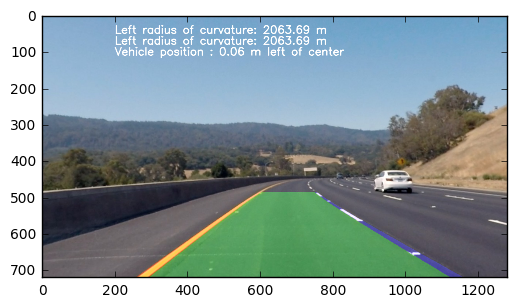

In [46]:
image = mpimg.imread('test_images/test3.jpg')
process_image.clear_cache = clear_cache
clear_cache()
%time process_image(image)
# %time process_image(image)
out = process_image(image)
plt.imshow(out)
plt.show()

In [47]:
#import imageio
#imageio.plugins.ffmpeg.download()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [56]:
vid_output = 'proj4_trim_out.mp4'
clip = VideoFileClip('proj4_trim.mp4')
clear_cache()
vid_clip = clip.fl_image(process_image)
%time vid_clip.write_videofile(vid_output, audio=False)


[MoviePy] >>>> Building video proj4_trim_out.mp4
[MoviePy] Writing video proj4_trim_out.mp4


 99%|█████████▉| 187/188 [01:09<00:00,  3.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: proj4_trim_out.mp4 

CPU times: user 1min 1s, sys: 15.6 s, total: 1min 16s
Wall time: 1min 11s


In [62]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

In [48]:
vid_output = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4')
clear_cache()
vid_clip = clip.fl_image(process_image)
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [05:20<00:00,  4.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 5min 10s, sys: 41.4 s, total: 5min 51s
Wall time: 5min 21s


In [49]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

In [ ]:
challenge_vid_output = 'chalenge_video_out.mp4'
clip = VideoFileClip('challenge_video.mp4')
clear_cache()
vid_clip = clip.fl_image(process_image)
%time vid_clip.write_videofile(challenge_vid_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_vid_output))

In [ ]:
harder_vid_output = 'harder_chalenge_video_out.mp4'
clip = VideoFileClip('harder_challenge_video.mp4')
clear_cache()
vid_clip = clip.fl_image(process_image)
%time vid_clip.write_videofile(harder_vid_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_vid_output))

Discussion

1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.

One issue is finding edges from input images. I am using a combination of sobel magnitudes of color space and gray scale.

When the lighting condition is poor, the white lane appears hard to be detected. 
I also found that shadow and tire marks on the road get in the way of lane lines detection. I was able to mask some of them out.

Perspective transform will fail sometimes, it is useful to have hardcoded source and destination point.

All the above may cause the pipeline to fail. If I were going to pursue this project further, I would like to spend more effort on edge finding. I would like to try some imgae processing libray like scikit-image.